In [13]:
%matplotlib inline

from eqcart import Cartogram
from chorogrid import Chorogrid
import geopandas as gpd
import json
import numpy as np
import seaborn as sns
import streamlit as st
import pandas as pd
import pydeck as pdk
import random
from cartutils import is_valid, delete_old_point, update_new_point, shunt_point


In [2]:
geodf = gpd.read_file("geo_data.csv")
geodf = geodf[geodf.id != '0']


In [3]:
geodf['centroid'] = list(zip(geodf['latitude'], geodf['longitude']))


In [4]:
num_x_grid = 40#25
num_y_grid = 50#20
if num_x_grid * num_y_grid < geodf.shape[0]:
    print("Add more dimensions to the grid. I.e., increase the num_x_grid, num_y_grid, or both")


In [5]:
geodf['latitude'] = geodf['latitude'].astype(float)
geodf['longitude'] = geodf['longitude'].astype(float)


In [6]:
xmax, xmin = geodf['latitude'].max(), geodf['latitude'].min()
ymax, ymin = geodf['longitude'].max(), geodf['longitude'].min()
x_range = xmax - xmin
y_range = ymax - ymin

geodf["x_bin"] = geodf["latitude"].apply(lambda x: int(num_x_grid*(x - xmin)/x_range))
geodf["y_bin"] = geodf["longitude"].apply(lambda y: int(num_y_grid*(ymax-y)/y_range))


In [7]:
point_position = geodf.set_index("id")[['x_bin', 'y_bin']].to_dict(orient='index')

x_coords_points = {}
y_coords_points = {}

for point in point_position:
    if point_position[point]['x_bin'] not in x_coords_points:
        x_coords_points[point_position[point]['x_bin']] = []
    if point_position[point]['y_bin'] not in y_coords_points:
        y_coords_points[point_position[point]['y_bin']] = []
    x_coords_points[point_position[point]['x_bin']].append(point)
    y_coords_points[point_position[point]['y_bin']].append(point)


In [8]:
coord_points = {} #{str(value['x_bin']) + "_" + str(value["y_bin"]): key for key, value in point_position.iteritems()}


In [10]:
for point, value in point_position.items():
    if (str(value["x_bin"]) + "_" + str(value["y_bin"])) not in coord_points:
        coord_points[str(value["x_bin"]) + "_" + str(value["y_bin"])] = []
    coord_points[str(value["x_bin"]) + "_" + str(value["y_bin"])].append(point)
iteration = 0


In [24]:
while not is_valid(coord_points):
    coord_to_shunt_from = max(coord_points, key=lambda x: len(coord_points[x]))
    ac_to_shunt = coord_points[coord_to_shunt_from][1]
    shunt_point(coord_to_shunt_from)
    iteration += 1


NameError: name 'coord_points' is not defined

<Axes: xlabel='x_bin', ylabel='y_bin'>

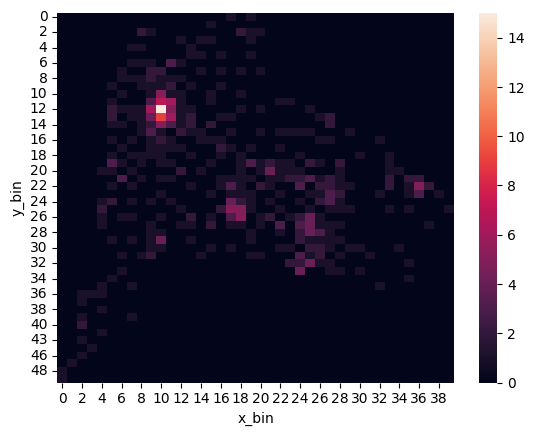

In [148]:
sns.heatmap(pd.crosstab(geodf["y_bin"], geodf["x_bin"]))


In [149]:
geodf['hex_x'] = geodf['id'].apply(lambda x: point_position[x.split("_")[-1]]["x_bin"])
geodf['hex_y'] = geodf['id'].apply(lambda x: point_position[x.split("_")[-1]]["y_bin"])
ids = geodf.id.tolist()
colors = ["#eeeeee"]*len(ids)


In [150]:
geodf


,longitude,latitude,fake_results,color,id,geometry,centroid,x_bin,y_bin,hex_x,hex_y
1,-1.928195,52.614276,0,"[255, 0, 0, 1]",1,None,"(52.61427612368785, -1.9281954903421805)",18,25,20,25
2,-2.365788,53.393541,0,"[255, 0, 0, 1]",2,None,"(53.39354061906345, -2.3657884892189305)",24,28,24,28
3,-1.399921,53.039952,0,"[255, 0, 0, 1]",3,None,"(53.039951775440315, -1.399920873555882)",22,21,22,21
4,-0.454579,50.927867,2,"[128, 128, 128, 1]",4,None,"(50.9278672769609, -0.4545789147339758)",6,14,6,14
5,-1.271945,53.093079,3,"[0, 255, 0, 1]",5,None,"(53.09307886525737, -1.271944658912507)",22,20,24,20
...,...,...,...,...,...,...,...,...,...,...,...
528,-2.274656,52.379592,3,"[0, 255, 0, 1]",528,None,"(52.37959158114841, -2.2746557104450624)",17,27,17,27
529,-2.281529,53.392526,3,"[0, 255, 0, 1]",529,None,"(53.3925257915588, -2.281528599761064)",24,27,25,27
530,-2.817415,50.919256,1,"[0, 0, 255, 1]",530,None,"(50.91925641316621, -2.817414947712852)",6,31,6,31
531,-1.092298,53.956749,1,"[0, 0, 255, 1]",531,None,"(53.95674881479849, -1.0922975048286059)",28,19,28,19


In [151]:
geodf.to_csv('geodf.csv', index=False)


In [152]:
# Use the CSV file path in Chorogrid constructor
cg = Chorogrid('geodf.csv', ids, colors, id_column="id")


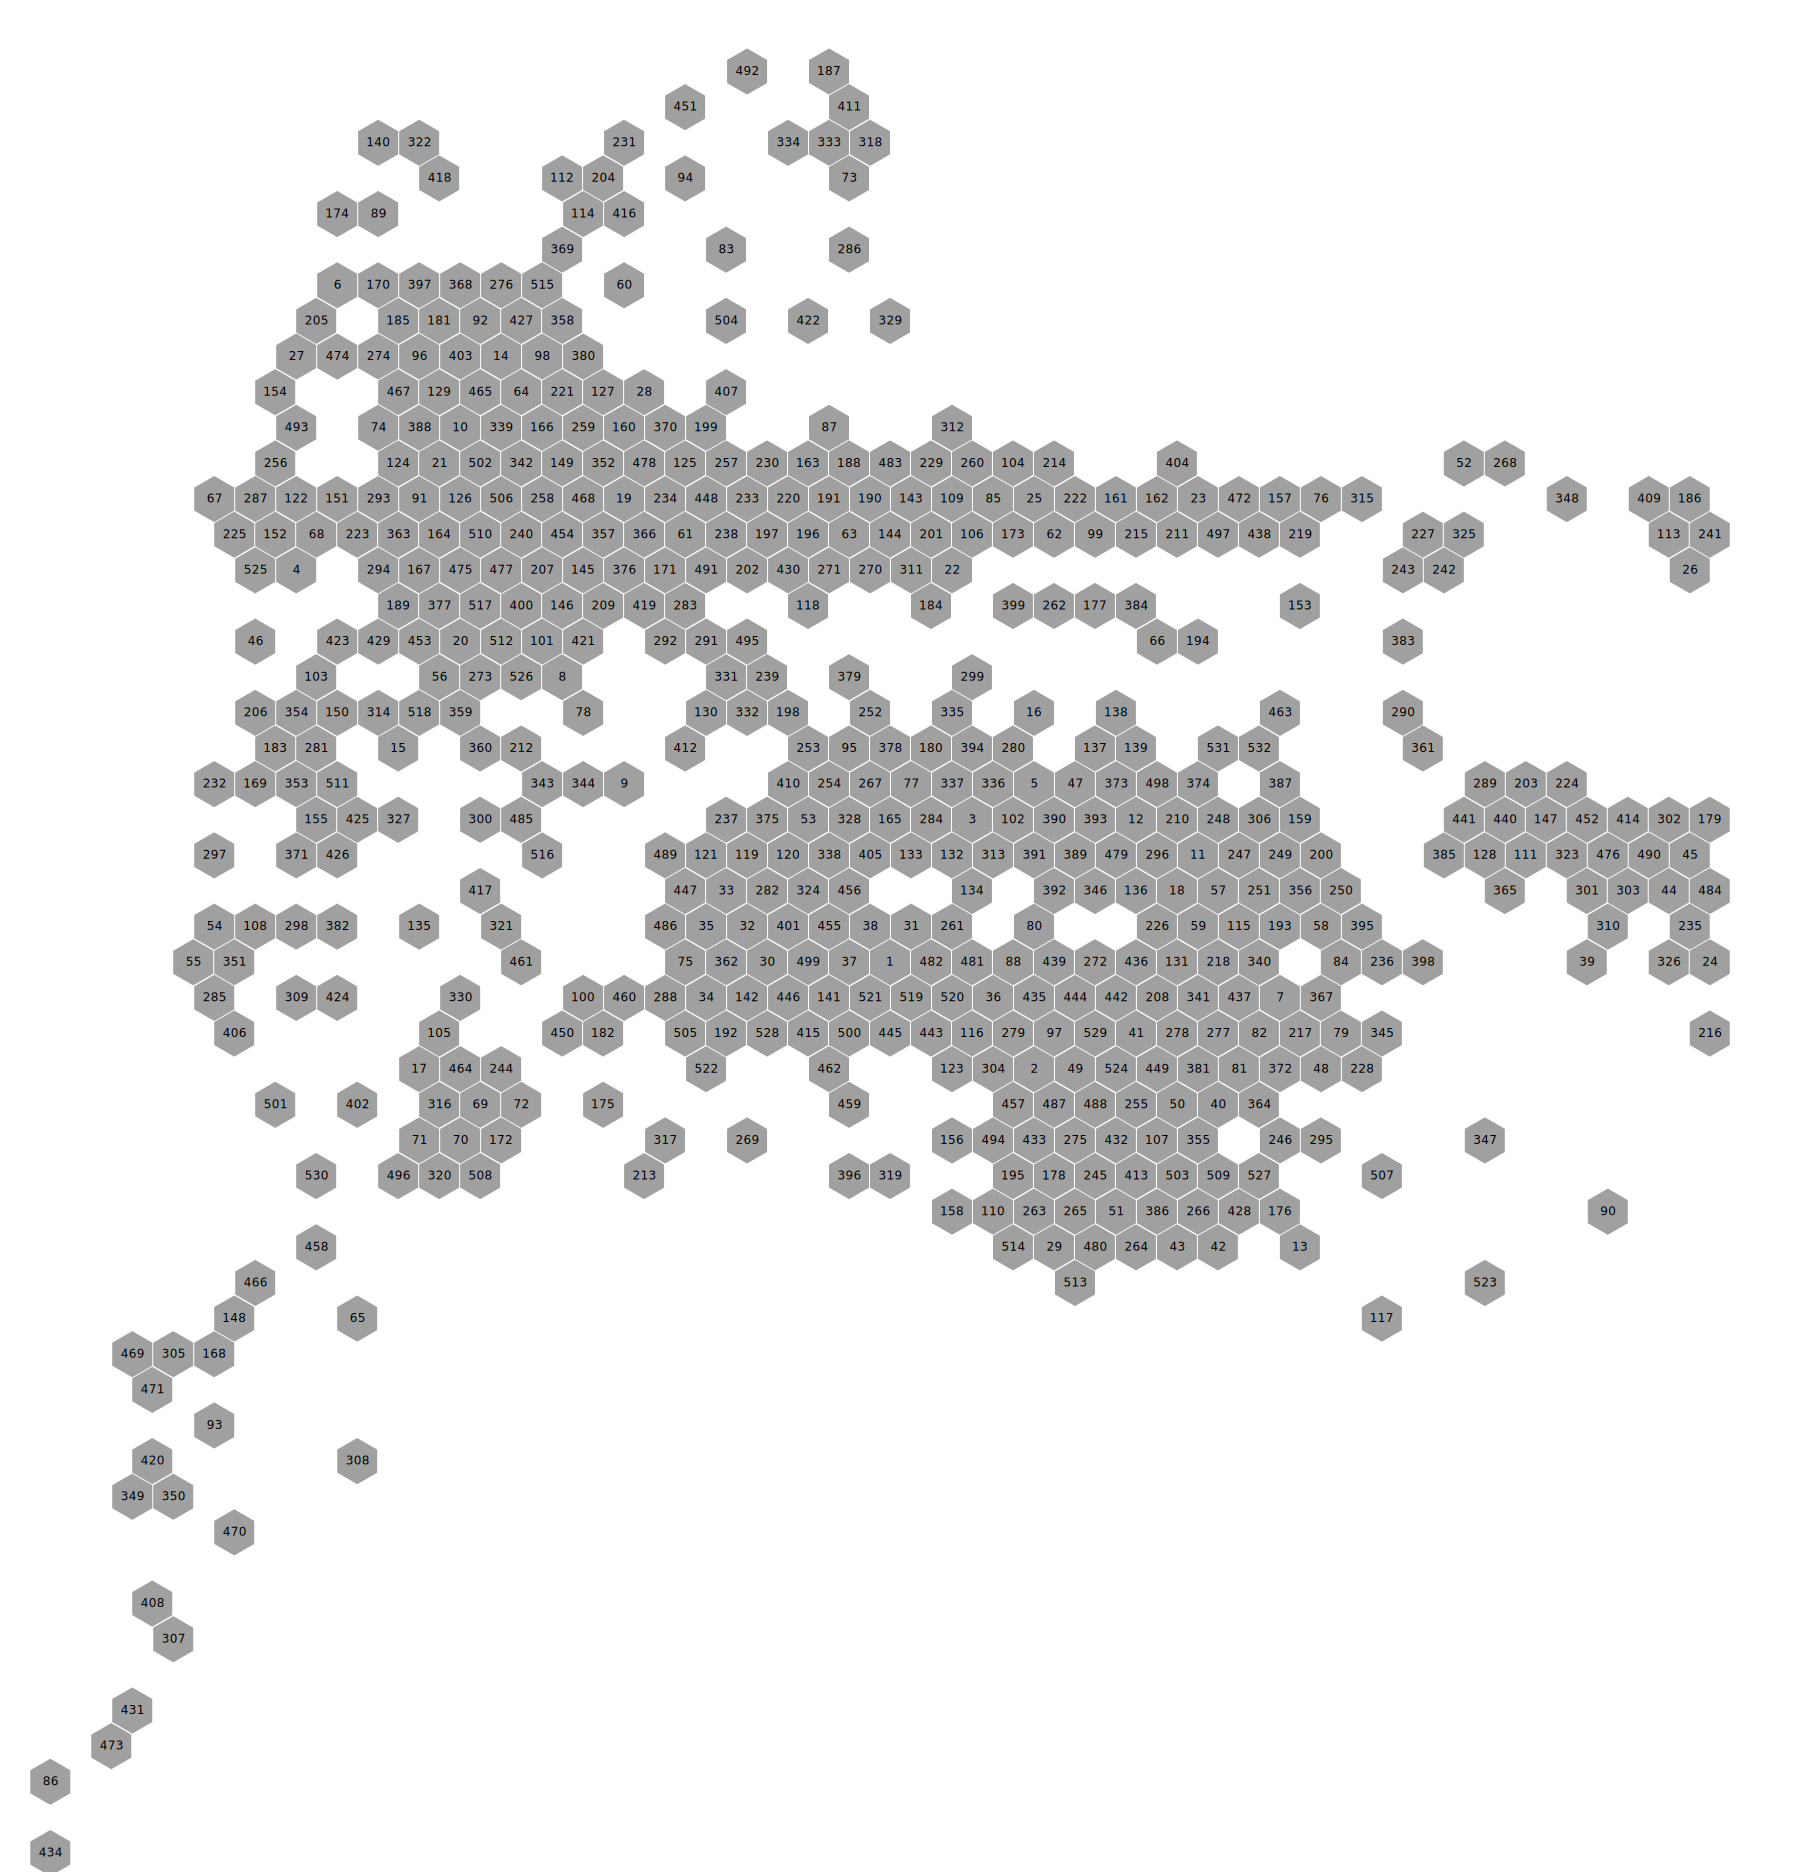

In [153]:
cg.draw_hex()
cg.done(save_filename="geo_uk_hex.svg", show=True)
